## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 7. Востановление пропусков и прогноз значений временного ряда.**


#### **7.1 Аналитечкие методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с базовыми, аналитическими методами восстановления временных рядов.
Для выполнения данного пункта из каждой группы методов, представленных в ***табл. 7.1*** вам необходимо выбрать по одному методу восстановления ряда. При работе с первой группой, вам необходимо самостоятельно реализовать выбранный метод.  

**Табл. 7.1** - Группы аналитических методов восстановления.
№|Название группы|Модели и методы|
--|----|----|
1|Заполнение существующими значениями ряда|Средним, медианной, Hot-Deck|
2|Заполнение на основе близки значений|[Интерполяция](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html),  [KNNi](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)|
3|На основе матричных разложений|[CD-Rec](#Fixme:Дат ссылку), [SVD](https://pypi.org/project/fancyimpute/)|

##### 7.1.1 Загрузка и подготовка данных

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_data = Path('datasets')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,0]
print(madrid.shape)

(25000,)


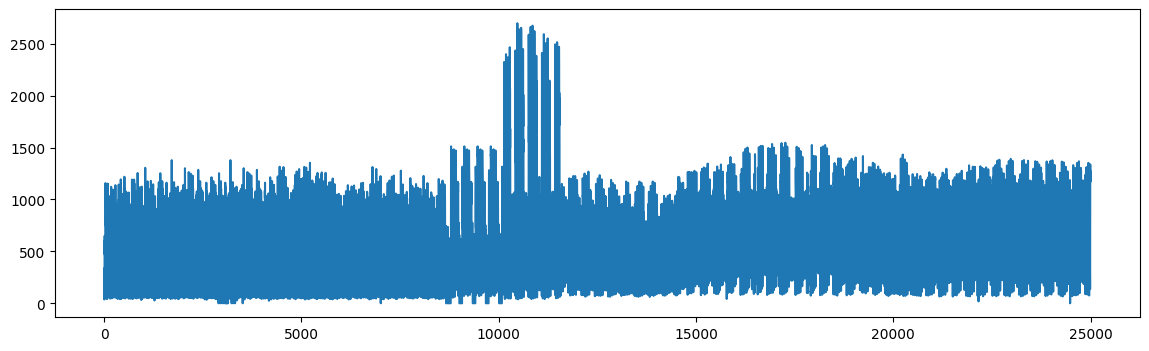

In [3]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(madrid[:])
plt.show()

Самостоятельно реализуйте функцию, принимающую на вход многомерный временной ряд и возвращающий:
1. Все подпоследовательности временного ряда, в которых некоторые значения временного ряда были заменены nan значениями.
2. Индексы пропущенных значений
   
Процент пропущенных значений должен регулироваться отдельным параметром.


In [4]:
import copy
import torch
import random

def add_nan(x, percent = 0.25):
    x_nan = copy.deepcopy(x)
    nan_len = x.shape[0] * percent
    nan_counter = 0

    for i in range(x_nan.shape[0]):
        if nan_counter <= nan_len and random.randint(0, 1):
            x_nan[i] = np.nan
            nan_counter += 1

    return x_nan, np.isnan(x_nan)

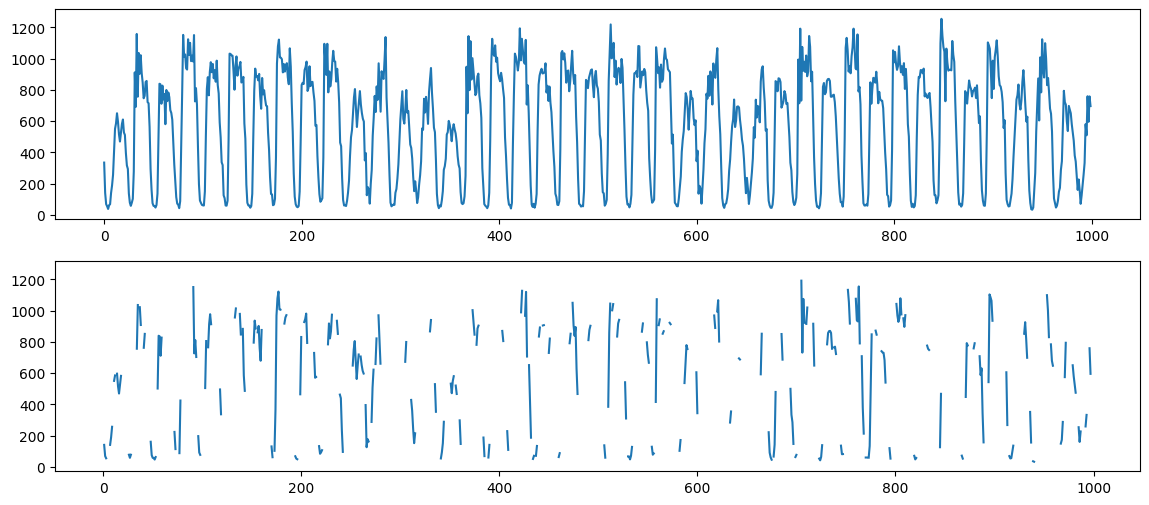

In [5]:
madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_with_nan[:1000])
plt.show()

In [6]:
recovery = {}

##### 7.1.2 Заполнение существующими значениями ряда


In [7]:
madrid_mean = madrid_with_nan.copy()
madrid_mean[index] = np.nanmean(madrid_mean)
recovery['mean'] = madrid_mean

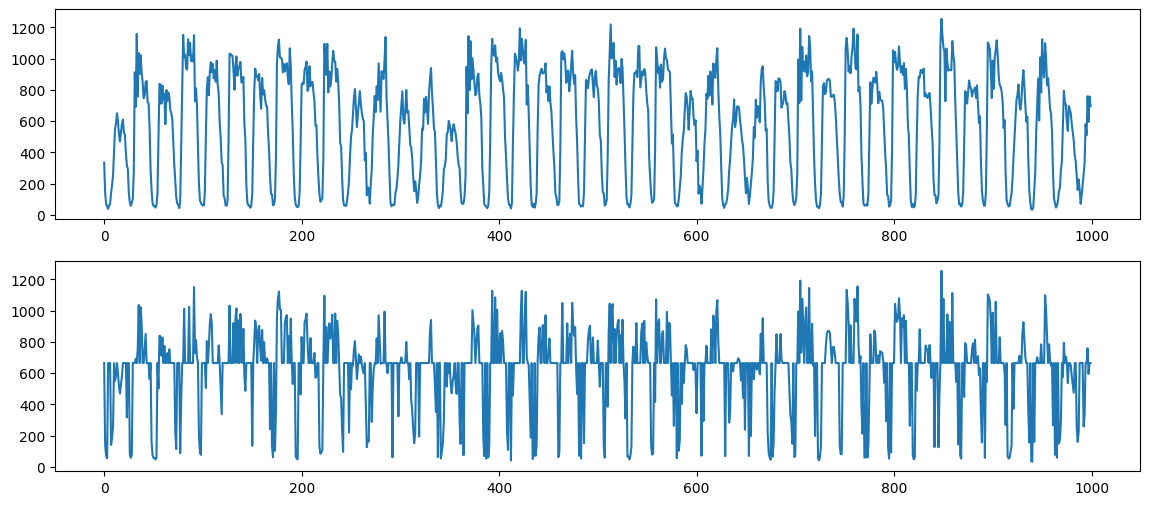

In [8]:
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_mean[:1000])
plt.show()

In [9]:
madrid_median = madrid_with_nan.copy()
madrid_median[index] = np.nanmedian(madrid_median)

In [10]:
recovery['median'] = madrid_median

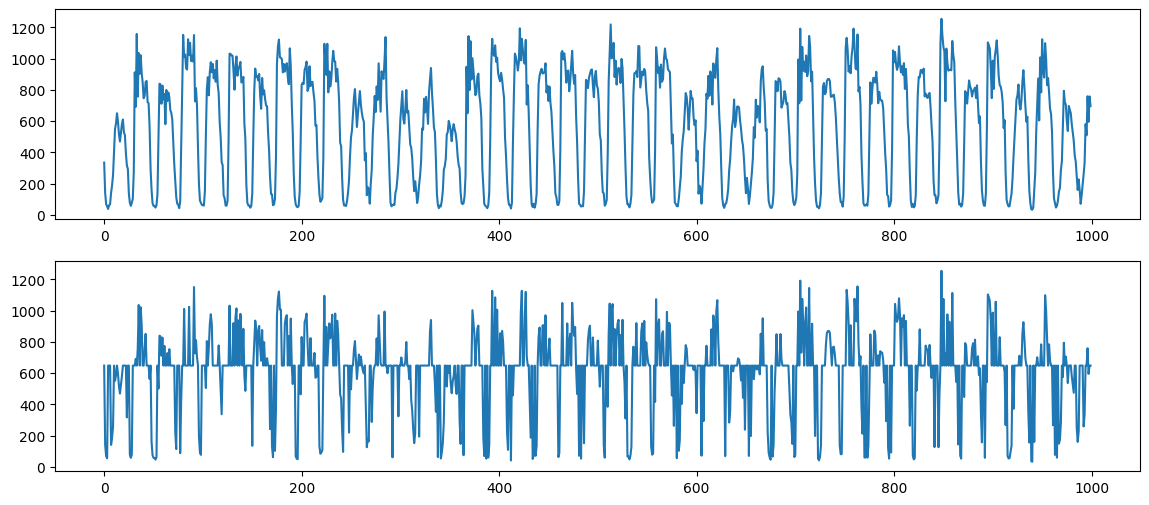

In [11]:
#madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_median[:1000])
plt.show()

Самостоятельно реализуйте один метод из первой группы ***табл. 7.1*** и проведите постановление данных, сохранив результаты восстановления.

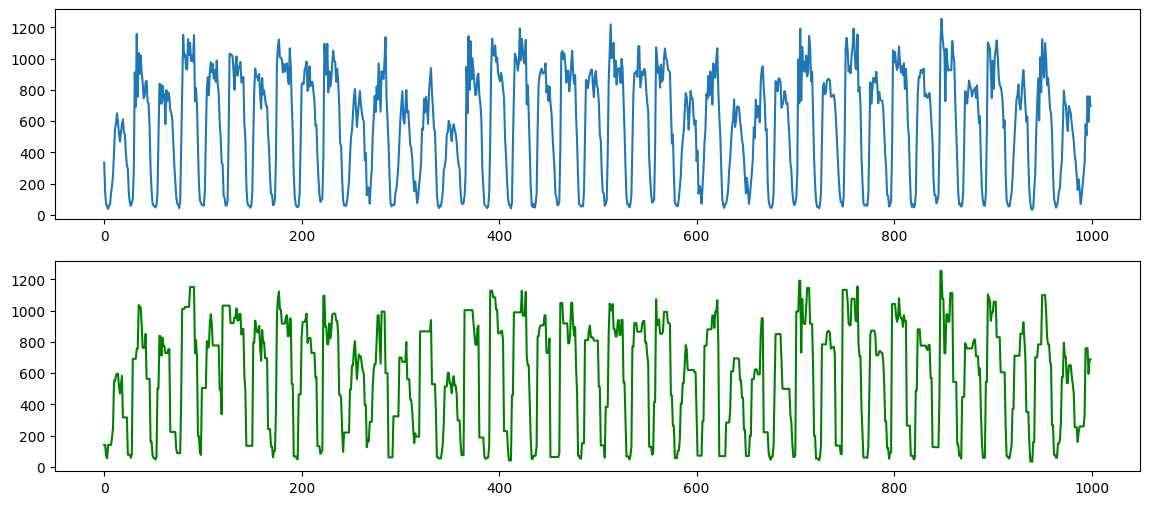

In [12]:
def hot_deck(ts, index):
  hot_deck = ts.copy()

  found_right = False
  for i in range(len(hot_deck)):
    if (index[i]):
      for right_ix in range(i, len(hot_deck)):
        if not (index[right_ix]):
           next = hot_deck[right_ix]
           found_right = True
           break
      if (found_right):
        hot_deck[i] = next
      else:
        hot_deck[i] = hot_deck[i-1]
  return hot_deck

madrid_hot_deck = hot_deck(madrid_with_nan, index)
recovery['hot_deck'] = madrid_hot_deck

fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_hot_deck[:1000], c='green')
plt.show()

##### 7.1.3 Заполнение на основе близких значений


Используя документацию одного из методов восстановления второй группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [13]:
from sklearn.impute import KNNImputer

In [14]:
def rolling_window(a, window, intersection=False):
    # result = torch.zeros(size=(a.shape[0],a.shape[1]))
    returns = []
    if intersection:  
        for i in range(0, a.shape[0]-window):
            returns.append(a[i:i + window])
    else:    
        for i in range(0, a.shape[0],window):
            returns.append(a[i:i + window])
    return np.stack(returns)
madrid_slice = rolling_window(madrid_with_nan, 100)


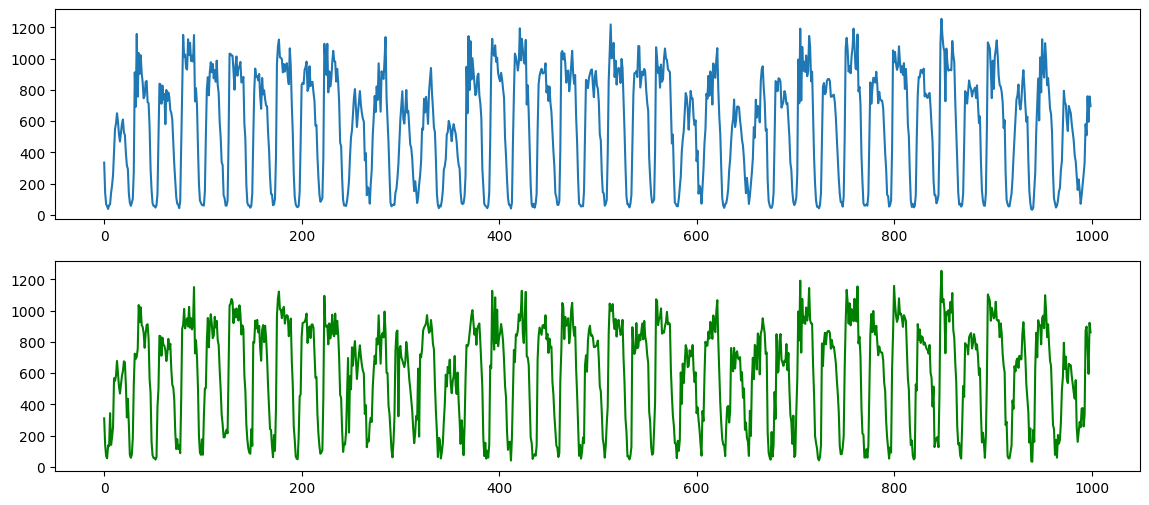

In [15]:
imputer = KNNImputer(n_neighbors=10)

madrid_knn = imputer.fit_transform(madrid_slice)
madrid_knn = madrid_knn.ravel()

recovery['knn'] = madrid_knn

fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_knn[:1000], c="green")
plt.show()

##### 7.1.4 Заполнение на матричных преобразований

Используя документацию одного из методов восстановления третей группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [16]:
!pip install fancyimpute


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [17]:
from fancyimpute import IterativeSVD

In [18]:
from sklearn.metrics import mean_squared_error

In [60]:
solver = IterativeSVD(rank=2)
madrid_iterative_svd = madrid_slice.copy()
madrid_iterative_svd = solver.fit_transform(madrid_iterative_svd)
madrid_iterative_svd = madrid_iterative_svd.ravel()

recovery['iterative_svd'] = madrid_iterative_svd

fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_iterative_svd[:1000], c='green')
plt.show()

[IterativeSVD] Iter 1: observed MAE=345.067589
[IterativeSVD] Iter 2: observed MAE=269.581658
[IterativeSVD] Iter 3: observed MAE=260.244728
[IterativeSVD] Iter 4: observed MAE=257.639773
[IterativeSVD] Iter 5: observed MAE=256.906232
[IterativeSVD] Iter 6: observed MAE=256.682575
[IterativeSVD] Iter 7: observed MAE=256.607006
[IterativeSVD] Iter 8: observed MAE=256.575664
[IterativeSVD] Iter 9: observed MAE=256.562350
[IterativeSVD] Iter 10: observed MAE=256.555924


TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

##### 7.1.5 Сравнение результатов восстановления.

Для каждой группы методов постройте методов основные метрики оценки качества постановления.
На основе метрик отберите лучшие методы постановления метрик и выберите лучшую группу методов.
Для лучших методов из каждой группы постройте графики сравнения реальных и восстановленных данных. Объясните результаты и сделайте вывод.



In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print('mean_squared_error')
MSE = {}
for method in recovery:
    MSE[method] = mean_squared_error(madrid, recovery[method])
    print(f'{method}: {mean_squared_error(madrid, recovery[method])}')

print('\nmean_absolute_error')
MAE = {}
for method in recovery:
    MAE[method] = mean_absolute_error(madrid, recovery[method])
    print(f'{method}: {mean_absolute_error(madrid, recovery[method])}')

print('\nr2_score')
R2 = {}
for method in recovery:
    R2[method] = r2_score(madrid, recovery[method])
    print(f'{method}: {r2_score(madrid, recovery[method])}')

mean_squared_error
mean: 43215.2438741494
median: 42701.2606
hot_deck: 19519.01184
knn: 12419.7432032
iterative_svd: 29613.08494322729

mean_absolute_error
mean: 84.60581199637315
median: 84.15484
hot_deck: 42.16672
knn: 38.923944
iterative_svd: 68.71163876899327

r2_score
mean: 0.7234439597006124
median: 0.7267331966997792
hot_deck: 0.8750880443774074
knn: 0.9205198283315292
iterative_svd: 0.8104910032025232


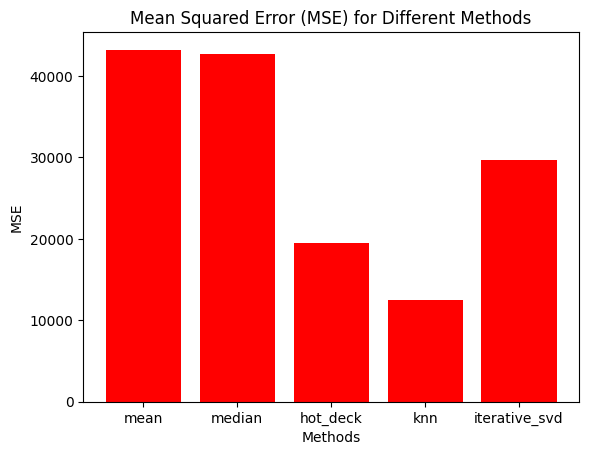

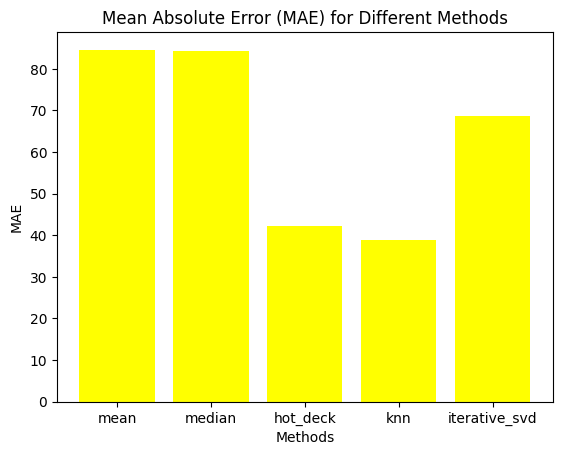

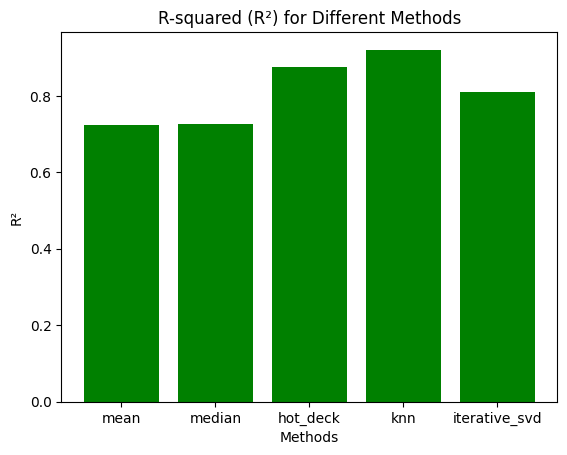

In [21]:
methods = recovery.keys()
# График для MSE
plt.bar(methods, MSE.values(), color='red')
plt.title('Mean Squared Error (MSE) for Different Methods')
plt.xlabel('Methods')
plt.ylabel('MSE')
plt.show()

# График для MAE
plt.bar(methods, MAE.values(), color='yellow')
plt.title('Mean Absolute Error (MAE) for Different Methods')
plt.xlabel('Methods')
plt.ylabel('MAE')
plt.show()

# График для R²
plt.bar(methods, R2.values(), color='green')
plt.title('R-squared (R²) for Different Methods')
plt.xlabel('Methods')
plt.ylabel('R²')
plt.show()

*Вывод*:

#### **7.2 Нейросетевые методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с некоторыми нейросетевыми методами восстановления временных рядов.
Для выполнения данного пункта вам предстоит самостоятельно реализовать структуру нейросетевой, модели основанной на GRU нейронах и сравнить ее с другими нейросетевыми методами восстановления При сравнении с 3 группой из **табл.7. 2** вам необходимо выбрать **один** метод восстановления. Основные блоки обработки данных будут реализованы с использованием Pytorch. Вам не запрещается использовать для реализации Keras.

**табл. 7.2** - Нейросетевые методы восстановления.
№|Название группы|Модели и методы|
--|-------------|----|
1|Линейные нейроны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)|
 2eкрркуретные нейронны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)|
3|Сложные структуры|[SAITS, BRITS, M-RNN](https://github.com/WenjieDu/PyPOTS)|

In [22]:
recovery_nn = {}

##### 7.2.1 Загрузка и подготовка данных

In [23]:
path_data = Path('datasets')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,:]
print(madrid.shape)

(25000, 10)


In [24]:
madrid_with_nan, index = add_nan(madrid, 0.25)

In [25]:
madrid_with_nan.shape

(25000, 10)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
madrid_normal_with_nan = scaler.fit_transform(madrid_with_nan)
rolling_madrid = rolling_window(madrid_normal_with_nan, 100, True)
train, test = train_test_split(rolling_madrid,shuffle=False, test_size=0.33)

##### 7.2.2 Базовая модель восстановления данных, построенная на нескольких слоях линейных нейронов.


Вам необходимо будет самостоятельно реализовать:
1. инициализацию nan значений какими либо другими значениями.
2. замер времени полного обучения и тестирования модели.

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [28]:
class LinearModel(nn.Module):
    def __init__(self, size_subsequent: int,dim = 1, nums_layers = 3, size_layers = 250):
        super().__init__()  
        
        self.size_subsequent = size_subsequent
        self.nums_layers = nums_layers*dim
        self.dim = dim
        self.size_layers = size_layers
        
        self.start_layers = nn.Sequential(nn.Flatten(),
                                          nn.Linear(size_subsequent*dim, self.size_layers),
                                          nn.LeakyReLU())
        self.model = nn.ModuleList([
                                        (nn.Sequential(
                                                nn.Linear(self.size_layers, self.size_layers), nn.LeakyReLU()
                                            ) 
                                        )
                                    for x in torch.arange(nums_layers)])
        self.model = nn.Sequential(*self.model)
        
        self.output = nn.Sequential(nn.Linear(self.size_layers,size_subsequent*dim),nn.Tanh())
        
    def forward(self, x):
        x = self.start_layers(x)
        
        x=self.model(x)
        x=self.output(x)
        return x.reshape(x.shape[0],self.size_subsequent,self.dim)

In [29]:
model = LinearModel(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)

print(train.shape,test.shape)
epochs = 100

(16683, 100, 10) (8217, 100, 10)


In [30]:
model

LinearModel(
  (start_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1000, out_features=250, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (output): Sequential(
    (0): Linear(in_features=250, out_features=1000, bias=True)
    (1): Tanh()
  )
)

In [31]:
import time
times_model = {}

In [32]:
import time
times_model = {}
model = model.to(device)
train_history = []
valid_history = []

start = time.time()
for epoch in np.arange(epochs):
    train_loss = 0
    valid_loss = 0

    for i, x in enumerate(train_loader):
        if x.shape[0] == batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X, percent)
            # Вставьте инициализацию нулями nan значений
            X[torch.isnan(X)] = 0.0
            recovery = model(X)
            loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss /= (i + 1)
    print('valid')
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0] == batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X, percent)
                X[torch.isnan(X)] = 0.0
                recovery = model(X)
                loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss /= (i + 1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch + 1} train:{train_loss}, valid:{valid_loss}')
end = time.time()


/var/folders/hz/r80mfqt101s40wh4dww9mcqr0000gn/T/ipykernel_10885/2852761456.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return x_nan, np.isnan(x_nan)
/var/folders/hz/r80mfqt101s40wh4dww9mcqr0000gn/T/ipykernel_10885/1556633448.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
/var/folders/hz/r80mfqt101s40wh4dww9mcqr0000gn/T/ipykernel_10885/1556633448.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
/Users/davidlimcher/Desktop/Python/TimeSeriesCourse/venv/lib/python3.11/site-p

valid


/var/folders/hz/r80mfqt101s40wh4dww9mcqr0000gn/T/ipykernel_10885/1556633448.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
/var/folders/hz/r80mfqt101s40wh4dww9mcqr0000gn/T/ipykernel_10885/1556633448.py:37: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])


epoch:1 train:0.03894979955621378, valid:0.039026710385268976
valid
epoch:2 train:0.03711521579131084, valid:0.03746106247453727
valid
epoch:3 train:0.03652266707000148, valid:0.03732525580382162
valid
epoch:4 train:0.03682192946673581, valid:0.037833143343297085
valid
epoch:5 train:0.036666519347564014, valid:0.03762803537150224
valid
epoch:6 train:0.03637926782199478, valid:0.03922596832289714
valid
epoch:7 train:0.036232552059365875, valid:0.03831473899673122
valid
epoch:8 train:0.0365369472781132, valid:0.03700746473127095
valid
epoch:9 train:0.036817191496948176, valid:0.038101425755393596
valid
epoch:10 train:0.0368623697480822, valid:0.03679205527774585
valid
epoch:11 train:0.0366019505108225, valid:0.03696054448337518
valid
epoch:12 train:0.036288863661702565, valid:0.03712609166264996
valid
epoch:13 train:0.03667478160611514, valid:0.03833525279868943
valid
epoch:14 train:0.03642530030645858, valid:0.03698928922761318
valid
epoch:15 train:0.036283553495888965, valid:0.03828057

In [33]:
times_model['linear']=end-start

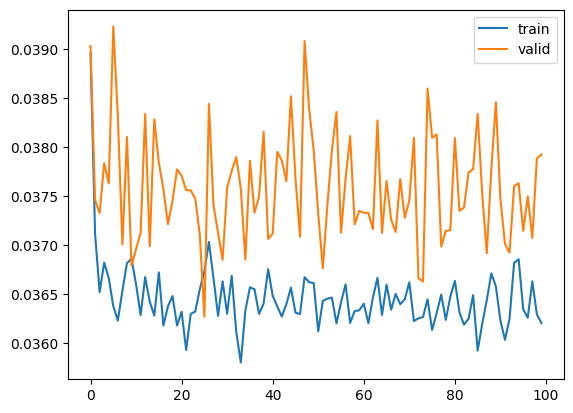

In [34]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [35]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        batch[nan]=0.0
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [36]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_linear = scaler.inverse_transform(test_madrid_normal)

In [37]:
recovery_nn['linear'] = test_linear

977825.8960788244


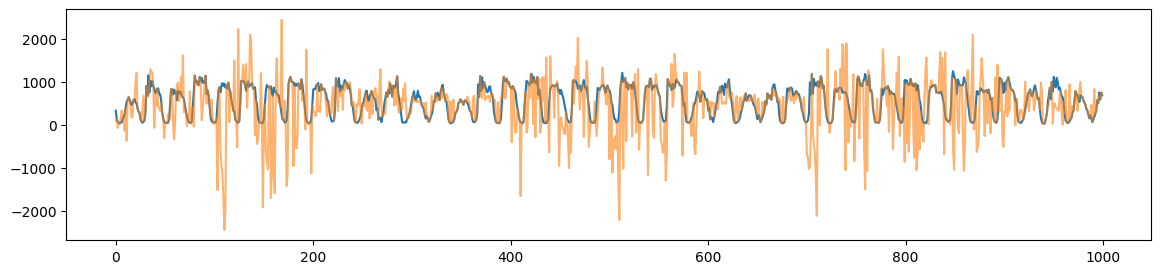

In [38]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_linear[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_linear[index].reshape(1,-1)))

##### 7.2.3 Реккурентная модель востановлениях данных


In [39]:
class EncoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=dim,
                          hidden_size=self.hidden_size)
        
        self.latten = nn.Linear(hidden_size*size_subsequent,latten_size)
        self.leaky = nn.LeakyReLU()
        self.fl = nn.Flatten()
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.leaky(x)
        #print(x.shape)
        x = self.fl(x)
        x = self.latten(x)
        return self.leaky(x)
        

In [40]:
class DecoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.latten_size=latten_size
        self.gru = nn.GRU(input_size=self.hidden_size,
                          hidden_size=dim)
        self.latten = nn.Linear(latten_size,hidden_size*size_subsequent)
        self.leaky = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.latten(x)
        x = x.view(-1, self.size_subsequent, self.latten_size)
        x = self.leaky(x)
        x, _ = self.gru(x)
        return self.leaky(x)
        

In [41]:
class TimeAE(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.encoder = EncoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size) 
        self.decoder = DecoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size) 
    def forward(self, x):
        x=self.encoder(x)
        x = self.decoder(x)
        return x

In [42]:
model = TimeAE(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)


epochs = 100

In [43]:
model

TimeAE(
  (encoder): EncoderGRU(
    (gru): GRU(10, 100)
    (latten): Linear(in_features=10000, out_features=100, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
    (fl): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): DecoderGRU(
    (gru): GRU(100, 10)
    (latten): Linear(in_features=100, out_features=10000, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
  )
)

In [44]:
model = model.to(device)
train_history = []
valid_history = []
start = time.time()

for epoch in np.arange(epochs):
    train_loss = 0
    valid_loss = 0

    for i, x in enumerate(train_loader):
        if x.shape[0] == batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X, percent)
            # Вставьте инициализацию нулями nan значений
            X[torch.isnan(X)] = 0.0

            recovery = model(X)
            loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss /= (i + 1)

    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0] == batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X, percent)
                # Инициализация нулями nan значений
                X[torch.isnan(X)] = 0.0

                recovery = model(X)
                loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss /= (i + 1)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch: {epoch + 1} train: {train_loss}, valid: {valid_loss}')
end = time.time()


/var/folders/hz/r80mfqt101s40wh4dww9mcqr0000gn/T/ipykernel_10885/2852761456.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return x_nan, np.isnan(x_nan)
/var/folders/hz/r80mfqt101s40wh4dww9mcqr0000gn/T/ipykernel_10885/2781128376.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
/var/folders/hz/r80mfqt101s40wh4dww9mcqr0000gn/T/ipykernel_10885/2781128376.py:21: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
/Users/davidlimcher/Desktop/Python/TimeSeriesCourse/venv/lib/python3.11/site-p

epoch: 1 train: 0.03861311462732796, valid: 0.036818958472373875
epoch: 2 train: 0.03672965990657779, valid: 0.03743522885695908
epoch: 3 train: 0.036688799338265396, valid: 0.03793662769156833
epoch: 4 train: 0.03628201881188086, valid: 0.03796434486212656
epoch: 5 train: 0.03643800305395291, valid: 0.03856467783393324
epoch: 6 train: 0.03661272895319023, valid: 0.03738143412006456
epoch: 7 train: 0.03647511623714162, valid: 0.03772045009184715
epoch: 8 train: 0.03643779472315905, valid: 0.037370309291421905
epoch: 9 train: 0.03632907132650244, valid: 0.037778325075673504
epoch: 10 train: 0.03664812598363193, valid: 0.03749329720934232
epoch: 11 train: 0.03651543308434815, valid: 0.03685032117158868
epoch: 12 train: 0.036332613570879704, valid: 0.037677724607462104
epoch: 13 train: 0.03622058588454778, valid: 0.037029640200410704
epoch: 14 train: 0.03666496123419183, valid: 0.03740109803602677
epoch: 15 train: 0.03640064249578792, valid: 0.037856841936360956
epoch: 16 train: 0.0364438

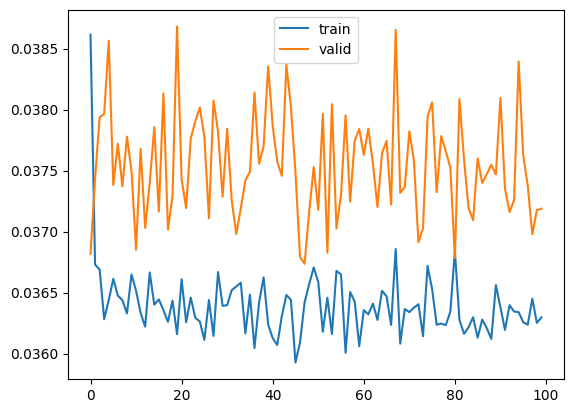

In [45]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [46]:
times_model['ae']=end-start

In [47]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        #
        
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [48]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_ae = scaler.inverse_transform(test_madrid_normal)

In [49]:
recovery_nn['test_ae'] = test_ae

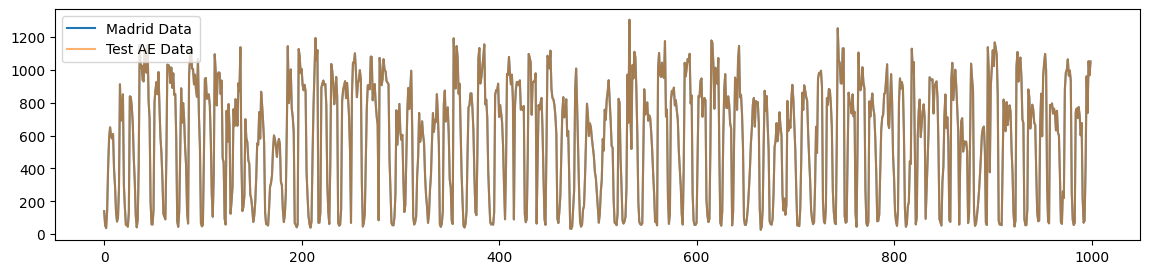

In [51]:
# Удаление строк с NaN
mask = ~np.isnan(madrid).any(axis=1) & ~np.isnan(test_ae).any(axis=1)
madrid_cleaned = madrid[mask]
test_ae_cleaned = test_ae[mask]

# Построение графиков
fig, ax = plt.subplots(figsize=(14, 3), ncols=1, nrows=1)
ax.plot(madrid_cleaned[:1000, 0], label='Madrid Data')
ax.plot(test_ae_cleaned[:1000, 0], alpha=0.6, label='Test AE Data')
ax.legend()
plt.show()

##### 7.2.4 Сложные модели нейросетевого восстановления данных


Вам необходимо выбрать одну модель из 3 группы таблицы 7.2 и используя документацию произвести восстановления того же ряда. Произведите замер времени.

In [52]:
!pip install pypots==0.0.9


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [53]:
from pypots.imputation import SAITS


In [54]:
model= SAITS(n_features=madrid.shape[1],
             n_steps=100,
             device=device,
             d_k=64,
             d_v=64,
             d_model=128,
             d_inner=128,
             n_head=4,
             n_layers=2,
             dropout=0.05,
             epochs=100)

Model initialized successfully. Number of the trainable parameters: 667608


In [55]:
start = time.time()
model.fit(train,test)
end = time.time()
times_model['saits']=end-start

epoch 0: training loss 0.1429, validating loss 0.0503
epoch 1: training loss 0.0826, validating loss 0.0418
epoch 2: training loss 0.0663, validating loss 0.0369
epoch 3: training loss 0.0588, validating loss 0.0337
epoch 4: training loss 0.0548, validating loss 0.0316
epoch 5: training loss 0.0519, validating loss 0.0295
epoch 6: training loss 0.0500, validating loss 0.0299
epoch 7: training loss 0.0486, validating loss 0.0286
epoch 8: training loss 0.0472, validating loss 0.0273
epoch 9: training loss 0.0462, validating loss 0.0272
epoch 10: training loss 0.0452, validating loss 0.0275
epoch 11: training loss 0.0443, validating loss 0.0285
epoch 12: training loss 0.0423, validating loss 0.0280
epoch 13: training loss 0.0411, validating loss 0.0272
epoch 14: training loss 0.0406, validating loss 0.0266
epoch 15: training loss 0.0402, validating loss 0.0267
epoch 16: training loss 0.0398, validating loss 0.0263
epoch 17: training loss 0.0394, validating loss 0.0262
epoch 18: training l

In [56]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
test_rolling_madrid = model.impute(test_rolling_madrid)


In [57]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_saits = scaler.inverse_transform(test_madrid_normal)

In [58]:
recovery_nn['saits'] = test_saits

28765.881168097636


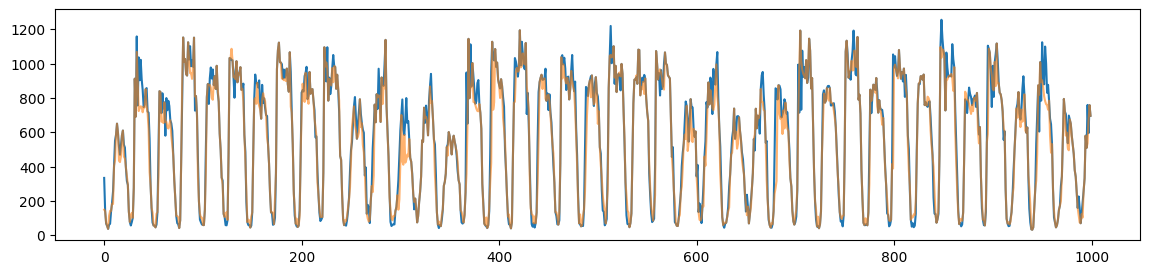

In [59]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_saits[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_saits[index].reshape(1,-1)))